# 线性回归的从零开始实现
## 1 import package
我们将从零开始实现整个方法，包括数据流水线、模型、损失函数和小批量随机梯度下降优化器

In [1]:
import matplotlib.pyplot as plt
import random
import torch
from d2l import torch as d2l

## 2 Dataset
根据带有噪声的线性模型构造一个人造数据集。 我们使用线性模型参数w=[2,−3.4]⊤、b=4.2和噪声项ϵ生成数据集及其标签：
y=Xw+b+ϵ

In [2]:
def synthetic_data(w, b, num_examples):  
    """生成 y = Xw + b + 噪声。"""
    X = torch.normal(0, 1, (num_examples, len(w)))#normal distribution ,mean=0,variance =0
    y = torch.matmul(X, w) + b #matirx multiple
    y += torch.normal(0, 0.01, y.shape)#noise
    return X, y.reshape((-1, 1))#-1表示让pytorch自己推导

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

# 3 visualize dataset
features 中的每一行都包含一个二维数据样本，labels 中的每一行都包含一维标签值（一个标量）

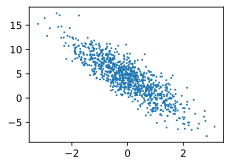

In [3]:
d2l.set_figsize()
#有些低版本的pytorch，需要将数据从计算图，抛离出来才能转到numpy里面
d2l.plt.scatter(features[:, (1)].detach().numpy(),
                labels.detach().numpy(), 1);

# 4 dataloader
定义一个data_iter 函数， 该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量

In [4]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    #创建一个indices：0-num_examples，样本的index，用来随机sample data
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        #获得batch的样本的index，最后一个batch可能不够，就取到最后就可以了
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
        #yield -- > 迭代返回
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.1600,  0.1191],
        [ 0.5945, -1.5594],
        [-1.9637,  0.0351],
        [-0.7419,  0.8366],
        [ 2.4367, -0.0185],
        [ 0.0104, -0.3028],
        [ 0.5152,  1.7128],
        [-0.1519,  0.2776],
        [ 1.0649, -0.9358],
        [-0.2298,  0.1150]]) 
 tensor([[ 3.4632],
        [10.7015],
        [ 0.1624],
        [-0.1204],
        [ 9.1401],
        [ 5.2503],
        [-0.6011],
        [ 2.9243],
        [ 9.4943],
        [ 3.3399]])


# 5 Model
## 5.1 params init

In [5]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

## 5.2 define model

In [6]:
def linreg(X, w, b):  
    """线性回归模型。"""
    return torch.matmul(X, w) + b

## 5.2 mseLoss

In [7]:
def squared_loss(y_hat, y):  
    """均方损失。"""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

# 6 optimizer

In [8]:
def sgd(params, lr, batch_size):  
    """小批量随机梯度下降。"""
    #更新参数是不需要计算梯度
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            #梯度不需要累积，与上次梯度无关
            param.grad.zero_()

# 7 Start training

In [9]:
#hyperparams
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        # X,y的小批量损失
        l = loss(net(X, w, b), y)
        # 计算梯度
        l.sum().backward()
        #梯度下降更新参数
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        #使用当前epoch训练的模型计算loss
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.036834
epoch 2, loss 0.000134
epoch 3, loss 0.000050
